**Chapter 2 – End-to-end Machine Learning project**

*Welcome to Machine Learning Housing Corp.! Your task is to predict median house values in Californian districts, given a number of features from these districts.*

*This notebook contains all the sample code and solutions to the exercices in chapter 2.*

# My notes are mixed in with the default text

**Note**: You may find little differences between the code outputs in the book and in these Jupyter notebooks: these slight differences are mostly due to the random nature of many training algorithms: although I have tried to make these notebooks' outputs as constant as possible, it is impossible to guarantee that they will produce the exact same output on every platform. Also, some data structures (such as dictionaries) do not preserve the item order. Finally, I fixed a few minor bugs (I added notes next to the concerned cells) which lead to slightly different results, without changing the ideas presented in the book.

## Steps
1. Look at the big picture
2. Get the data
3. Discover and visualize the data to gain insites
4. Prepare the data for ML algos
5. Select the model and train it
6. Fine tune your model
7. Present your solution
8. Launch, monitor, maintain system
    - I feel like there should have been a step to build out a system

## Look at the Big Picture
We're gona build a model of housing prices to predict median house price for a "district".

### Frame the problem
What are we trying to accomplish? Probably not to just make a model.  This matters because it dictates what your outputs should be and how much time you should spend working on this.  This chapters scenario is that the outputs of this model (predicted median price) will be fed into a nother ML system (figure 2-2 in the book, it's a diagram of a pipeline). along with other signals.  The downstream system will determine if it is worth investing.  So the stakes are high, there's money to be made.

### What will the solution look like?
- Currently prices are estimated by experts. Time consuming.  Results off by about 10% sometimes. 
- What kind of modeling problem is this? supervised or unsupervised or Reinforcement learning?  Classification? Regression? Batch learning or online learning?
    - this is supervised, our data is labeled.
    - This is a typical regression problem; we're predicting and output.
        - Multivariate regression because we're gonna use multiple features.
    - Batch learning: the data won't change and is small.

### Select a performance measure
Typically [RSME](https://en.wikipedia.org/wiki/Root-mean-square_deviation). If there are a lot of outliers, Mean Absolute Error might be good. Absolute takes the place of the root: it still makes values Positive, but reduces the effect of the outliers.  Both of these are measures of distance between two vectors.  Both of these are called norms, like RMSE is the l2 norm. MAE is l1.

### Check the assumptions
In this scenario you'd probably assume that they next step of the process wants a dollar value. But it's worth checking. What if it wanted categories? then you wouldn't need to worry about how close you are as much.

### Side note: Pipelines
- Typically run asynchronously.
    - each componenet is kinda self contained and can be run as needed.
        - interface between sections is data storage.
        - Makes the pipeline resiliant to downages in components, but allows for errors to go undetected for a while.

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
# This makes an images directory relative to the current working directory (i think)
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    """
    Saves figures in a directory called "images". Should be in the same dir
    as this notebook.
    """
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Get the data
Data is California Housing Prices dataset from the now defunct StatLib repository. Based on 1990 Census.  There is a README in the datasets/housing directory.

writing a function to get the data is nice because it'll help if the data changes, and/or if you need the data on another machine.

In [2]:
import os
import tarfile
from six.moves import urllib

# If I were writing this, I probably wouldn't make these globals.
# They aren't even used that much.
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    """
    Fetches data from internet, decompresses it, and saves it in the datasets
    directory, which should be in the same dir as this notebook.
    """
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [3]:
# fetch data from the internet and and save it.
fetch_housing_data()

In [4]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [5]:
# finally load the data into memory
housing = load_housing_data()

## Look at the data
Here's our first look.  Each row is one district. A district census block group. IDK why the book wants to call it a district. A block group is the smallest geographical unit for which the U.S. Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people).

In [6]:
# here's our first look.
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [7]:
housing.shape

(20640, 10)

In [8]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [9]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [10]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


**A quick note on plotting with matplotlib**

Matplotlib needs to be given a user specified backend in order to be able to draw things.  That can be drawing on your screen, or saving files, or something else.  The magic function `%matplotlib inline` tells matplotlib to use Jupyter's own backend.

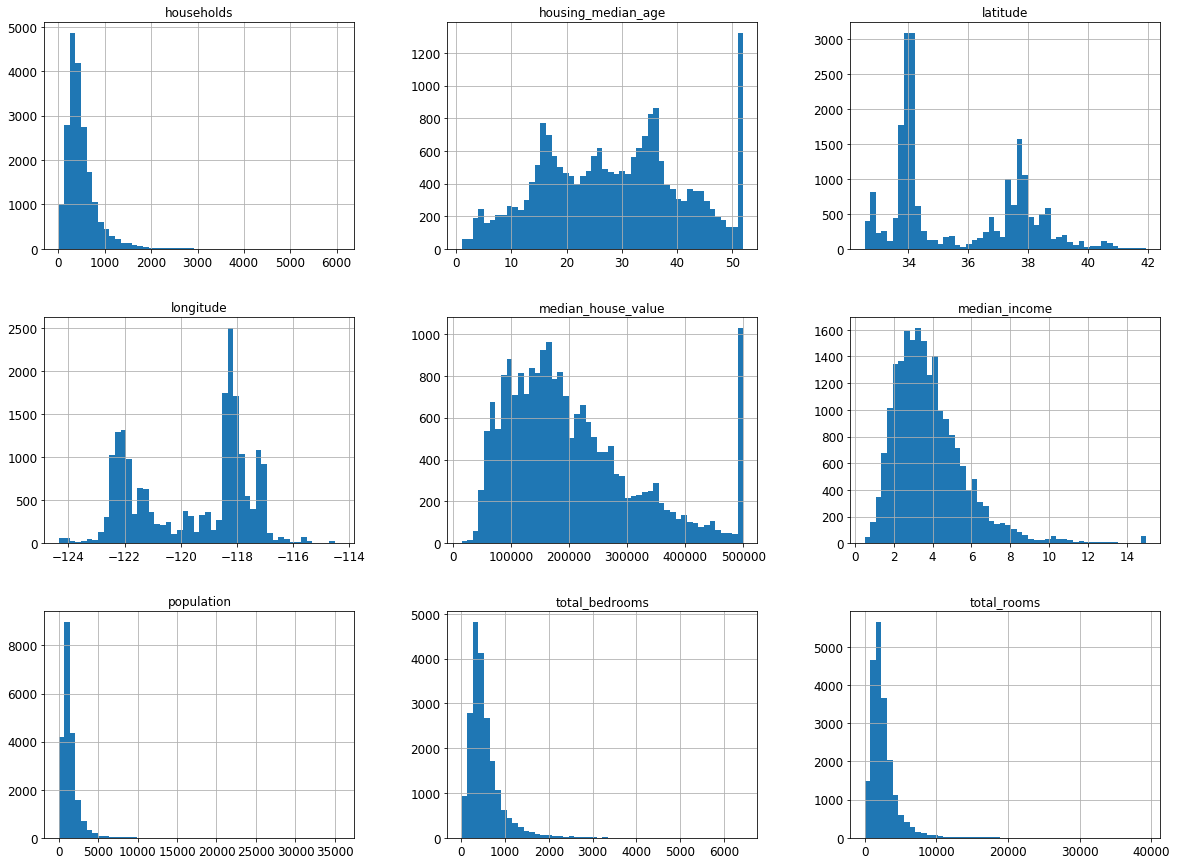

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
# save_fig("attribute_histogram_plots")
plt.show()

Notice a few things in these histograms:
1. Median income doesn't look like it's in USD! It's capped at 15.0001 and 4.999 (confirmed below).  It's not uncommon to scale or normallize data, but it's good to be aware.
2. Housing median age and median house value were also capped.  The latter may be serious because that is our target in this chapter.  If it turns out that we need to predict values beyond $500,000, then we have two options:
    - Collect more data.
    - Remove those districts from the dataset.
3. These attributes all exist on different scales. More on that later.
4. Many histograms are tail heavy.  It would be nicer if they were bell shaped. We'll try and transform them later (hopefully with more discussion)

In [12]:
# confirm values, could also check the describe() above.
print(housing.median_income.max())
print(housing.median_income.min())

15.0001
0.4999


## Make a Test data set
Make it, set it aside, and never look at it.

Do it now before you get a better feel for the data.  If you get a better feel for it you might start over fitting in your head.  This is called the data snooping bias.

Side note, what about all the experts who practice ML in their fields of expertise? They have tons of knowledge built up already. That seems similar to the data snooping bias, but I don't think their expertise would be a hinderance.

A more permanent way of selecting the same-ish test data in a dataset that updates is to make immutable unique identifiers for each point of data, and then hash the identifiers, and then keep the last bit of the hash. Then, set aside and data whose hash is less then or equal to 51 (which is about ~20% of 256).

If you data doesn't have an identifier you can make one.  You could make one by builiding off of the most stable features of the data. In our dataset those would be latitude and longitude.

### Many methods of making a test set
The following shows a few functions that make test sets.

In [13]:
# to make this notebook's output identical at every run
np.random.seed(42)

In [14]:
import numpy as np

# For illustration only. Sklearn has train_test_split()
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [15]:
# split out the test and train data
# test is set to 20% of the whole dataset.
train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


In [16]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    """
    This is one way of making a test set. Hashed the id column, keeps
    some number of bits (just the last?) and then keeps the data when the 
    bit is less then the test_ratio percentage of 256. Or something like that.
    """
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    """
    Uses that bit hacking function to return a percentage of the data for testing.
    """
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

The implementation of `test_set_check()` above works fine in both Python 2 and Python 3. In earlier releases, the following implementation was proposed, which supported any hash function, but was much slower and did not support Python 2:

In [17]:
import hashlib

def test_set_check(identifier, test_ratio, hash=hashlib.md5):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

If you want an implementation that supports any hash function and is compatible with both Python 2 and Python 3, here is one:

In [18]:
def test_set_check(identifier, test_ratio, hash=hashlib.md5):
    return bytearray(hash(np.int64(identifier)).digest())[-1] < 256 * test_ratio

In [19]:
housing_with_id = housing.reset_index()   # adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [20]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [21]:
housing_with_id.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,-122192.12
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,-122182.14
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,-122202.15
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,-122212.15
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,-122212.15


But we should just used sci-kit learns' function.

In [22]:
from sklearn.model_selection import train_test_split
# use sklearn's function
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

## Re-sampling
So far we have considered purely random splits. Which is fine, if you data is large enough. But you should make sure your data is representative.  This reminds me of something from work: There's a few steps in the CoD and Mortality processes where they have to resample the data.  The idea is like this: you know that a population is 50% percent women and 50% men. But your survey of that population is 40% men and 60% women. Since you already knew that the pop should be 50/50 split you have a reason to make your survey data match that distribution, or else it is not representative.  So you could re-sample it to fit the distribution of your survey to the distribution of the population.

The book has a similar example. When a sampling survey tries to mimic the underlying population distribution like this it's called _"stratified sampling"_.

### Stratified Sampling
The population is divided into homogenous subgroups called strata (singular stratum), and the correct number of instances is sampled from each stratum to guarantee that the test set is representative of the overall population.

We've decided that the median income variable is really important. We want to make sure that the test dataset is representative of income variable categories in the whole dataset.  In order to check that we gotta bin it into stratum since Income is continuous.  It's important to have enough stratum, but we also have to have enough data in each category. So we shouldn't make too many strata. 

Here's the distribution of median income:

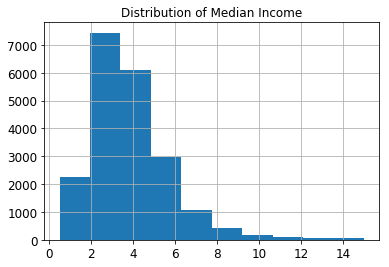

In [23]:
housing["median_income"].hist();
plt.title("Distribution of Median Income");

This stratifies the income variable:

In [24]:
# Divide by 1.5 to limit the number of income categories
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
# Label those above 5 as 5
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

In [25]:
housing["income_cat"].value_counts()

3.0    7236
2.0    6581
4.0    3639
5.0    2362
1.0     822
Name: income_cat, dtype: int64

Let's take a look at the distribution of our strata. Note that this is in the full dataset!

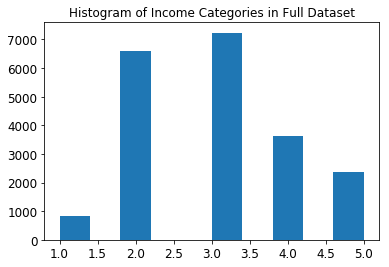

In [26]:
housing["income_cat"].hist(grid=False);
plt.title("Histogram of Income Categories in Full Dataset");

Text says "you are now ready to do stratified sampling based on the income category". Sci kit learn has a class for this.

Let's look at the docstring first.

In [27]:
from sklearn.model_selection import StratifiedShuffleSplit

In [28]:
StratifiedShuffleSplit?

Init signature: StratifiedShuffleSplit(n_splits=10, test_size='default', train_size=None, random_state=None)
Docstring:     
Stratified ShuffleSplit cross-validator

Provides train/test indices to split data in train/test sets.

This cross-validation object is a merge of StratifiedKFold and
ShuffleSplit, which returns stratified randomized folds. The folds
are made by preserving the percentage of samples for each class.

Note: like the ShuffleSplit strategy, stratified random splits
do not guarantee that all folds will be different, although this is
still very likely for sizeable datasets.

Read more in the :ref:`User Guide <cross_validation>`.

Parameters
----------
n_splits : int, default 10
    Number of re-shuffling & splitting iterations.

test_size : float, int, None, optional
    If float, should be between 0.0 and 1.0 and represent the proportion
    of the dataset to include in the test split. If int, represents the
    absolute number of test samples. If None, the value is se

In [29]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

Let's check that that worked.

In [30]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

In [31]:
housing["income_cat"].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

Let's make a comparison between all the sampling strategies

In [32]:
# make a comparison between all the sampling strategies
def income_cat_proportions(data):
    """
    Make a comparison between all the sampling strategies
    """
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

You can see how the stratified column closely matches the overall column, and that the strat. % error is smaller than Rand. %error.

In [33]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1.0,0.039826,0.039729,0.040213,0.973236,-0.243309
2.0,0.318847,0.318798,0.324370,1.732260,-0.015195
3.0,0.350581,0.350533,0.358527,2.266446,-0.013820
4.0,0.176308,0.176357,0.167393,-5.056334,0.027480
5.0,0.114438,0.114583,0.109496,-4.318374,0.127011


Now that we've check the stratification of our sampling scheme and know it worked, let's drop the category columns. This way the data is back to it's original state.  Note that, even though we've dropped the strata, the test set was still built in such a way as to maintain the underlying distribution of income in the full dataset.

In [34]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# Discover and visualize the data to gain insights
Time to look more in depth at our data.  We've set aside our test set so it's time to get a real feel for the training data.  Let's make a copy of the data just to keep the training data seperate from our explorations.

In [35]:
housing = strat_train_set.copy()

## Visualizating Geographic Information

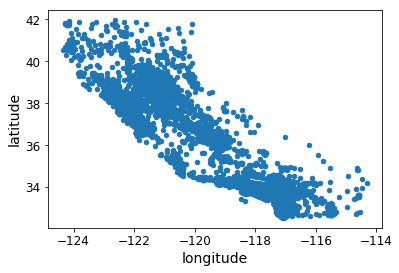

In [36]:
housing.plot(kind="scatter", x="longitude", y="latitude");
# save_fig("bad_visualization_plot")

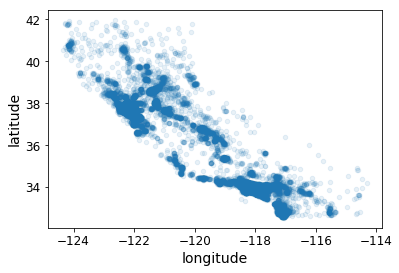

In [37]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1);
# save_fig("better_visualization_plot")

The argument `sharex=False` fixes a display bug (the x-axis values and legend were not displayed). This is a temporary fix (see: https://github.com/pandas-dev/pandas/issues/10611). Thanks to Wilmer Arellano for pointing it out.

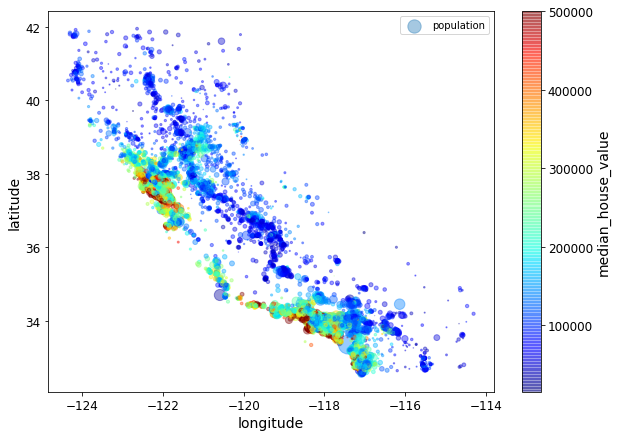

In [38]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False);
plt.legend();
# save_fig("housing_prices_scatterplot")

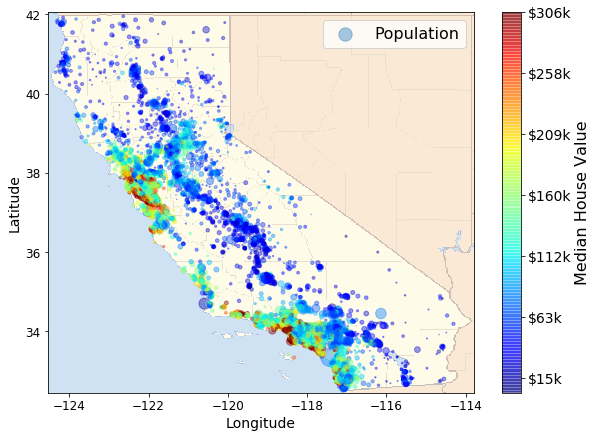

In [39]:
import matplotlib.image as mpimg
california_img=mpimg.imread(PROJECT_ROOT_DIR + '/images/end_to_end_project/california.png')
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=housing['population']/100, label="Population",
                       c="median_house_value", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
# save_fig("california_housing_prices_plot")
plt.show()

### What the maps tell us
- Housing prices (color) are related to population density (size)
- Proximity to Ocean looks important
    - In S. CA though. In N. CA there doesn't look like it's as big a deal.

Book says that a clustering Algorithm will probably be useful to detect clusters. 

## Looking for Correlations
since the dataset is small we can compute the correlation of each variable with every other variable.

In [40]:
corr_matrix = housing.corr()

In [41]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

Scatter/hist of some of the numberical variable:

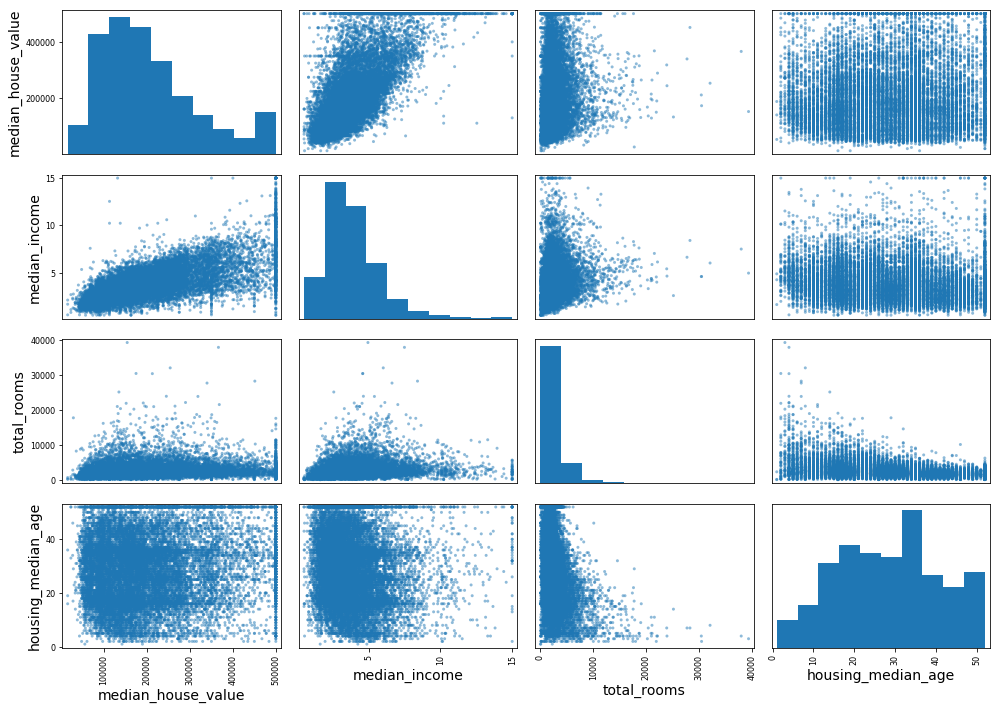

In [42]:
# from pandas.tools.plotting import scatter_matrix # For older versions of Pandas
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(14, 10));
plt.tight_layout();
# save_fig("scatter_matrix_plot")

Look at how there's a lot of maxed/mined out values.

Median Income is strongest with Median House Value. 

Note that there are some horizontal lines! At 500,000, 450,000, 350,000, maybe 280,000. So there's lots of house values at those prices regardless of income.  It kind of makes sense that some round numbers would be chosen, but we wouldln't want any ML algorithm learning to reproduce that pattern.

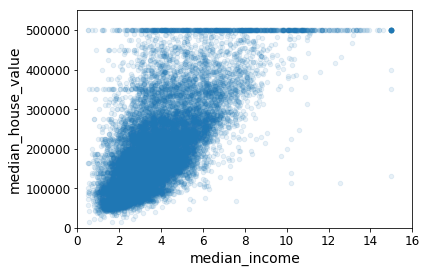

In [43]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1);
plt.axis([0, 16, 0, 550000]);
# save_fig("income_vs_house_value_scatterplot")

### Experimenting with Attribute Combinations
So far we've found a few potentially interesting correlations, and found a few quirks of the data we might want to clean out before starting any ML algorithms.  We also saw some tail heavy distributions, and we might want to transform them.  We haven't gone into why really yet but it's been mentioned that having them be normally distributed could be good.

One last thing we might want to do before diving into preparing the data for ML is trying out some attribute combinations.  For example, number of rooms in a district isn't that useful for figuring out what the cost is.  What you really want is the number of rooms per household.  We can make some combinations like this with the data we have and create more potentially useful information.

In [44]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

Note: there was a bug in the previous cell, in the definition of the `rooms_per_household` attribute. This explains why the correlation value below differs slightly from the value in the book (unless you are reading the latest version).

Now let's look at the correlation again.

In [45]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

The new bedrooms_per_room is much more correlated with median house value than total number of rooms or bedrooms on their own.

This kind of combination exploration does not have to be absolutely thorough, it can be iterative.

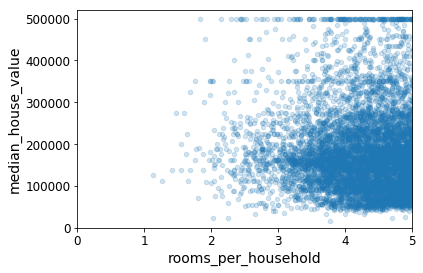

In [46]:
housing.plot(kind="scatter", x="rooms_per_household", y="median_house_value",
             alpha=0.2)
plt.axis([0, 5, 0, 520000])
plt.show()

In [47]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000
mean,-119.575834,35.639577,28.653101,2622.728319,534.973890,1419.790819,497.060380,3.875589,206990.920724,5.440341,0.212878,3.096437
std,2.001860,2.138058,12.574726,2138.458419,412.699041,1115.686241,375.720845,1.904950,115703.014830,2.611712,0.057379,11.584826
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900,14999.000000,1.130435,0.100000,0.692308
25%,-121.800000,33.940000,18.000000,1443.000000,295.000000,784.000000,279.000000,2.566775,119800.000000,4.442040,0.175304,2.431287
50%,-118.510000,34.260000,29.000000,2119.500000,433.000000,1164.000000,408.000000,3.540900,179500.000000,5.232284,0.203031,2.817653
75%,-118.010000,37.720000,37.000000,3141.000000,644.000000,1719.250000,602.000000,4.744475,263900.000000,6.056361,0.239831,3.281420
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500001.000000,141.909091,1.000000,1243.333333


# Prepare the data for Machine Learning algorithms
You should make functions for this step because:
- This will let you reproduce it easier, maybe even on other datasets
- You will gradually build up a library of code you can refer to and pull from.
- Once you make this process a system/pipeline, you can use the functions to transform the data as new data comes in from the source
- This will let you easily try transformations out and see which works best.

But first lets go back to a clean dataset by copying strat_train_set again.  Let's separate the _predictors_ from the _labels_ since we don't necessariliy want to apply the same transformations to the predictors and the target values.  Note that `drop()` creates a copy of the data and does not affect strat_train_set.

In [48]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN,4.625369,0.223852,2.094395
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN,6.008850,0.159057,2.707965
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN,4.225108,0.241291,2.025974
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND,5.232295,0.200866,4.135977
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN,4.505810,0.231341,3.047847


In [49]:
strat_train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN


In [50]:
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

In [51]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN


In [52]:
housing_labels.head()

17606    286600.0
18632    340600.0
14650    196900.0
3230      46300.0
3555     254500.0
Name: median_house_value, dtype: float64

## Data Cleaning
Most ML algos cannot work with missing features.  Let's make a new function to take care of em.  Earlier we saw that total bedrooms was missing some values. 

Three options:
1. Drop the corresponding districts entirely
    - Each row is a district.
2. Get rid of the whole attrribute
3. Set the values to some other value (0, the mean, the median, etc)
    - Read up on [Inputation](https://en.wikipedia.org/wiki/Imputation_(statistics))

In [53]:
# these are all the rows with missing values in any column. But they're all in total_bedrooms
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head() 
sample_incomplete_rows.isnull().any()

longitude             False
latitude              False
housing_median_age    False
total_rooms           False
total_bedrooms         True
population            False
households            False
median_income         False
ocean_proximity       False
dtype: bool

In [54]:
sample_incomplete_rows.dropna(subset=["total_bedrooms"])    # option 1

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [55]:
sample_incomplete_rows.drop("total_bedrooms", axis=1)       # option 2

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,3468.0,1405.0,3.1662,<1H OCEAN


In [56]:
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) # option 3
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662,<1H OCEAN


If you choose option 3, be sure to save the value for later.  What you made is a value based on your training data set. You'll need this training set value to fill in missing data in the test set.

### Sklearn Imputer
Sklearn has a tool for filling in missing data: [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html). 

#### How to use it
First create an Imputer instance and specify what kind of replacement you want (Median for us this time). Since median only works on numerical values, we need to create a copy of the data without the text attribute `ocean_proximity`

> If it were me doing this from scratch I would only apply the imputer to the numerical columns instead of dropping columns or making a new dataset.

Then we can fit the Imputer instance to the data with the `.fit()` method.  The Imputer instance computes the median of each column and stores that in its `statistics_` variable (attribute). For now only total bedrooms had missing values but once our system "goes live" there could be other columns with missing values. 

Now we can use the Imputer instance to transform the training dataset.  The result is a plain Numpy array containing the transformed features.  It's simple to put that back into a Pandas DataFrame.

In [57]:
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy="median", verbose=True)

Remove the text attribute because median can only be calculated on numerical attributes:

In [58]:
# housing_num = housing.drop('ocean_proximity', axis=1)
housing_num = housing.select_dtypes(include=[np.number])

In [59]:
imputer.fit(housing_num)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median',
    verbose=True)

In [60]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

Check that this is the same as manually computing the median of each attribute:

In [61]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

Transform the training set:

In [62]:
X = imputer.transform(housing_num)

In [63]:
# put X back into a dataframe
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index = list(housing.index.values))

In [64]:
# select the rows that used to have nulls and see that they no longer do!
housing_tr.loc[sample_incomplete_rows.index.values]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662


In [65]:
imputer.strategy

'median'

In [66]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns)
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
1,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
2,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
4,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


## Scikit-Learn Design
There are consistent core design attributes to SciKit-Learn's API.  See: https://arxiv.org/pdf/1309.0238v1.pdf

- **Consistency**: All objects share a consistent and simple interface.
    - _Estimators_: Any object that can estimate some parameters based on a dataset is called an _estimator_ (e.g., an _imputer_ is an esitmator). The stimation itself is performed by the `fit()` method, and it takes only a daataset as a parameter (or two for supervised learning algorithms; the second dataset contains the labels). Any other parameter needed to guide the estimation process is considered a hyperparameter (such as an `imputer`'s `strategy`), and it must be set as an instance variable (generally via a constructor parameter).
    - _Transformers_. Some estimators (such as an imputer) can also transform a dataset; these are called transformers. Once again, the API is quite simple: the transformation is performed by the `transform()` method with the dataset to transform as a parameter. It returns the transformed dataset. This transformation generally relies on the learned parameters, as is the case for an imputer. All transformers also have a convenience method called `fit_transform()` that is equivalent to calling `fit()` and then `transform()` (but sometimes `fit_transform()` is optimized and runs much faster).
    - _Predictors_. Finally, some estimators are capable of making predictions given a dataset; they are called predictors. For example, the `LinearRegression` model in the previous chapter was a predictor: it predicted life satisfaction given a country’s GDP per capita. A predictor has a `predict()` method that takes a dataset of new instances and returns a dataset of corresponding predictions. It also has a `score()` method that measures the quality of the predictions given a test set (and the corresponding labels in the case of supervised learning algorithms).
- **Inspection**. All the estimator’s hyperparameters are accessible directly via public instance variables (e.g., `imputer.strategy`), and all the estimator’s learned parameters are also accessible via public instance variables with an underscore suffix (e.g., `imputer.statistics_`).
- **Nonproliferation of classes**. Datasets are represented as NumPy arrays or SciPy sparse matrices, instead of homemade classes. Hyperparameters are just regular Python strings or numbers.
- **Composition**. Existing building blocks are reused as much as possible. For example, it is easy to create a Pipeline estimator from an arbitrary sequence of transformers followed by a final estimator.
- **Sensible defaults**. Scikit-Learn provides reasonable default values for most parameters, making it easy to create a baseline working system quickly.


### Handling Text and Categorical Attributes.
Now let's preprocess the categorical input feature, `ocean_proximity`:

In [67]:
housing_cat = housing[['ocean_proximity']]
housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


Most ML algorithsm perfer to work with numbers , so let's convert these categories from text to numbers.  We could use [panda's `factorize` method](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.factorize.html).

**Warning**: earlier versions of the book used the `LabelEncoder` class or Pandas' `Series.factorize()` method to encode string categorical attributes as integers. However, the `OrdinalEncoder` class that is planned to be introduced in Scikit-Learn 0.20 (see [PR #10521](https://github.com/scikit-learn/scikit-learn/issues/10521)) is preferable since it is designed for input features (`X` instead of labels `y`) and it plays well with pipelines (introduced later in this notebook). For now, we will import it from `future_encoders.py`, but once it is available you can import it directly from `sklearn.preprocessing`.

In [68]:
from future_encoders import OrdinalEncoder

In [69]:
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

Now the `housing_cat_encoded` is purely numerical.

In [70]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

One problem with doing this is now ML algorithms will assume that these numbers we made are _ordinal_.  For example, it will be assumbed that two nearby values are more similar than two distant values.  This is not actually the vase to we gotta do something about that.  

#### One-Hot Encoding
One common solution is to turn each category into a binary value.  This is called _One-Hot Encoding_.

- https://en.wikipedia.org/wiki/One-hot
- https://www.kaggle.com/dansbecker/using-categorical-data-with-one-hot-encoding
- http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

A lot of Machine learning algorithms will not work if stuff is _not_ One-Hot Encoded:
>This encoding is needed for feeding categorical data to many scikit-learn
estimators, notably linear models and SVMs with the standard kernels.


Scikit Learn has a one-hot encoder.

**Warning**: earlier versions of the book used the `LabelBinarizer` or `CategoricalEncoder` classes to convert each categorical value to a one-hot vector. It is now preferable to use the `OneHotEncoder` class. Right now it can only handle integer categorical inputs, but in Scikit-Learn 0.20 it will also handle string categorical inputs (see [PR #10521](https://github.com/scikit-learn/scikit-learn/issues/10521)). So for now we import it from `future_encoders.py`, but when Scikit-Learn 0.20 is released, you can import it from `sklearn.preprocessing` instead:

In [71]:
from future_encoders import OneHotEncoder

In [72]:
OneHotEncoder?

Init signature: OneHotEncoder(n_values=None, categorical_features=None, categories=None, sparse=True, dtype=<class 'numpy.float64'>, handle_unknown='error')
Docstring:     
Encode categorical integer features as a one-hot numeric array.

The input to this transformer should be an array-like of integers or
strings, denoting the values taken on by categorical (discrete) features.
The features are encoded using a one-hot (aka 'one-of-K' or 'dummy')
encoding scheme. This creates a binary column for each category and
returns a sparse matrix or dense array.

By default, the encoder derives the categories based on the unique values
in each feature. Alternatively, you can also specify the `categories`
manually.
The OneHotEncoder previously assumed that the input features take on
values in the range [0, max(values)). This behaviour is deprecated.

This encoding is needed for feeding categorical data to many scikit-learn
estimators, notably linear models and SVMs with the standard kernels.

Note

In [73]:
housing_cat_encoded

array([[0.],
       [0.],
       [4.],
       ...,
       [1.],
       [0.],
       [3.]])

Note that the output is a scipy Sparse Matrix

In [74]:
# One Hot Encode the housing categories
cat_encoder = OneHotEncoder()  # this step could be skipped.
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

By default, the `OneHotEncoder` class returns a sparse array, but we can convert it to a dense array if needed by calling the `toarray()` method:

In [75]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

Alternatively, you can set `sparse=False` when creating the `OneHotEncoder`:

In [76]:
cat_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [77]:
# see how the underlying, original categories are stored? they're kept in public instance variables with an underscore suffix.
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

## Custom Transformers
Let's create a custom transformer to add extra attributes.

At times you'll have to make your own transformers.  You want it to work with Sci Kit Learn's functionality, so that you can take advantage of its features (such as pipelines), and since sklearn relies on duck-typing and not inheritance, all you need to do is create a class and implement three methods:
1. `fit()` (returning `self`)
2. `transform()`
3. `fit_transform()`
You can get the last one for free simply by adding `TransformerMixin` as a base class.  Alos, if you add `BaseEstimator` as a base class (and avoid `*args` and `**kwargs` in your constructor) you will get two extra methods (`get_params()` and `(set_params()`) that will be useful for automatic hypterparameter tuning

This small class adds the combined attributes we discussed earlier:

In [78]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [79]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"])
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
0,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944
1,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796
2,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597
3,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598
4,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785


In this example the transformer has one hyperparameter, `add_bedrooms_per_room`, set to `True` by default. This hyperparameter will aloow you to easily find out wheter adding ths attribute helps the ML algos or not. More generally, you can add a hyperparameter to gate any data perparation step that you are not 100% sure about.  The more you automate these prep steps the more combinations you can automatically try out, making it more likely that you will find a great combination and save time

## Feature Scaling

One of the most important Transformations is _feature scaling_. With few exceptions, ML algos don'g do well when the input numerical attributes have very different scales.  This is the case for our housing data: the total number of rooms ranges from 6 to 39,320, while the median incomes range from 0 to 15. 

Note that scaling target values is often not required.

There are two common ways to get all attributes to have the same scale:
1. min-max scaling
2. standardization

### Min-Max scaliing
AKA _normalization_ is simple: Values are  shifted and rescaled so that they end up ranging from 0 to 1. We do this by subtracting the min value and dividing by the max minus the min.  Sklearn provides a transformer called `MinMaxScaler` for this.  It has a `feature_range` hyperparameter that lets you change the range to something other than 0 to 1. 

### Standardization
This one is pretty different: First subtracts the mean values (so that the standardized values will all have zero mean), and then divides by the variance so that the resulting distribution of the data has unit variance.  Unlike Min-Max, standardization does not bound values to a specific range, which could be a problem for some ML algos (E.g., Neural networks).  However, Standardization is less affected by outliers. Sklearn provides `StandardScalar` for this.

## Transformation Pipelines

There are a lot of data transformation steps that need to be executed in the right order. Fortunately, Scikit learn provides the `Pipeline` class to help with such sequences of transformations/  Here is a small pipeline for the numerical attributes:

The `Pipeline` constructor takes a list of name/estimator pairs defining a sequence of steps.  All but the last estimator must be transformers. That is, they must have a `fit_transform()` method.  The names can be anything (as long as there are no double underscores).

When you call the pipelines's `fit()`, it calls `fit_transform()` sequentially on all the transformers, passing the output of each as the parameter to the next one, until it reaches the last transformer, for which it just calls the `fit()` method.

The Pipeline exposes the same methods as the final estimator.  In this example, the last esitmator is a StandardScaler, which is a transformer, so the pipeline has a transform() method that applies all the transforms to the data in a sequence. 

In [80]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [81]:
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

It would be nice if we could feed a Pandas DataFrame containing non-numerical columns straight into our pipeline, instead of having to manually extract the numerical columns into a Numpy array.  There is nothing in sklearn (yet) to hand pandas dataframes, but there will be in 0.20.

**Warning**: earlier versions of the book applied different transformations to different columns using a solution based on a `DataFrameSelector` transformer and a `FeatureUnion` (see below). It is now preferable to use the `ColumnTransformer` class that will be introduced in Scikit-Learn 0.20. For now we import it from `future_encoders.py`, but when Scikit-Learn 0.20 is released, you can import it from `sklearn.compose` instead:

In [82]:
from future_encoders import ColumnTransformer

In [83]:
ColumnTransformer?

Init signature: ColumnTransformer(transformers, remainder='drop', sparse_threshold=0.3, n_jobs=1, transformer_weights=None)
Docstring:     
Applies transformers to columns of an array or pandas DataFrame.

EXPERIMENTAL: some behaviors may change between releases without
deprecation.

This estimator allows different columns or column subsets of the input
to be transformed separately and the results combined into a single
feature space.
This is useful for heterogeneous or columnar data, to combine several
feature extraction mechanisms or transformations into a single transformer.

Read more in the :ref:`User Guide <column_transformer>`.

.. versionadded:: 0.20

Parameters
----------
transformers : list of tuples
    List of (name, transformer, column(s)) tuples specifying the
    transformer objects to be applied to subsets of the data.

    name : string
        Like in Pipeline and FeatureUnion, this allows the transformer and
        its parameters to be set using ``set_params`` and s

In [84]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [85]:
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [86]:
housing_prepared.shape

(16512, 16)

For reference, here is the old solution based on a `DataFrameSelector` transformer (to just select a subset of the Pandas `DataFrame` columns), and a `FeatureUnion`:

In [87]:
from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
class OldDataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

Now let's join all these components into a big pipeline that will preprocess both the numerical and the categorical features:

In [88]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

old_num_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

old_cat_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(cat_attribs)),
        ('cat_encoder', OneHotEncoder(sparse=False)),
    ])

In [89]:
from sklearn.pipeline import FeatureUnion

old_full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", old_num_pipeline),
        ("cat_pipeline", old_cat_pipeline),
    ])

In [90]:
old_housing_prepared = old_full_pipeline.fit_transform(housing)
old_housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

The result is the same as with the `ColumnTransformer`:

In [91]:
np.allclose(housing_prepared, old_housing_prepared)

True

# Select and train a model 

In [95]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [96]:
# let's try the full preprocessing pipeline on a few training instances
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]


Compare against the actual values:

In [97]:
print("Labels:", list(some_labels))

Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [98]:
some_data_prepared

array([[-1.15604281,  0.77194962,  0.74333089, -0.49323393, -0.44543821,
        -0.63621141, -0.42069842, -0.61493744, -0.31205452, -0.08649871,
         0.15531753,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , -0.90896655, -1.0369278 ,
        -0.99833135, -1.02222705,  1.33645936,  0.21768338, -0.03353391,
        -0.83628902,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, -0.31365989, -0.15334458,
        -0.43363936, -0.0933178 , -0.5320456 , -0.46531516, -0.09240499,
         0.4222004 ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [-0.01706767,  0.31357576, -0.29052016, -0.36276217, -0.39675594,
         0.03604096, -0.38343559, -1.04556555, -0.07966124,  0.08973561,
        -0.19645314,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.49247384, -0.65929936, -0

In [99]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848923

In [100]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

49439.89599001897

In [101]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [102]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

# Fine-tune your model

In [103]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [104]:
print(tree_rmse_scores)

[70232.0136482  66828.46839892 72444.08721003 70761.50186201
 71125.52697653 75581.29319857 70169.59286164 70055.37863456
 75370.49116773 71222.39081244]


In [105]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [70232.0136482  66828.46839892 72444.08721003 70761.50186201
 71125.52697653 75581.29319857 70169.59286164 70055.37863456
 75370.49116773 71222.39081244]
Mean: 71379.07447706361
Standard deviation: 2458.3188204349362


In [106]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard deviation: 2731.674001798349


In [107]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

C:\Users\Dillon\AppData\Local\conda\conda\envs\handson_ml\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [108]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

21941.911027380233

In [109]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [51650.94405471 48920.80645498 52979.16096752 54412.74042021
 50861.29381163 56488.55699727 51866.90120786 49752.24599537
 55399.50713191 53309.74548294]
Mean: 52564.19025244012
Standard deviation: 2301.873803919754


In [110]:
scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

count       10.000000
mean     69052.461363
std       2879.437224
min      64969.630564
25%      67136.363758
50%      68156.372635
75%      70982.369487
max      74739.570526
dtype: float64

In [111]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

111094.6308539982

In [112]:
%%time
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

Wall time: 0 ns


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

The best hyperparameter combination found:

In [113]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [114]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

Let's look at the score of each hyperparameter combination tested during the grid search:

In [115]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63647.85444595992 {'max_features': 2, 'n_estimators': 3}
55611.50159876327 {'max_features': 2, 'n_estimators': 10}
53370.06407363344 {'max_features': 2, 'n_estimators': 30}
60959.138858487866 {'max_features': 4, 'n_estimators': 3}
52740.58416665252 {'max_features': 4, 'n_estimators': 10}
50374.14214614731 {'max_features': 4, 'n_estimators': 30}
58661.2866461823 {'max_features': 6, 'n_estimators': 3}
52009.973979776936 {'max_features': 6, 'n_estimators': 10}
50154.11777368494 {'max_features': 6, 'n_estimators': 30}
57865.36168014446 {'max_features': 8, 'n_estimators': 3}
51730.07550866553 {'max_features': 8, 'n_estimators': 10}
49694.85143334442 {'max_features': 8, 'n_estimators': 30}
62874.407393096284 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54643.49980834466 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59437.89228588419 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52735.358293621044 {'bootstrap': False, 'max_features': 3, 'n_estimators':

In [116]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.048090,0.002976,0.002479,0.000457,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-3.850668e+09,-4.134078e+09,...,-4.051049e+09,1.431223e+08,18,-1.065637e+09,-1.104930e+09,-1.116843e+09,-1.112813e+09,-1.129842e+09,-1.106013e+09,2.173798e+07
1,0.152554,0.005129,0.006794,0.000405,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-3.052380e+09,-3.250767e+09,...,-3.092639e+09,1.306954e+08,11,-5.932728e+08,-5.871800e+08,-5.780873e+08,-5.713421e+08,-5.797944e+08,-5.819353e+08,7.584886e+06
2,0.451945,0.006444,0.018983,0.000604,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-2.692176e+09,-3.017478e+09,...,-2.848364e+09,1.604534e+08,9,-4.385337e+08,-4.394786e+08,-4.374429e+08,-4.374715e+08,-4.451903e+08,-4.396234e+08,2.883885e+06
3,0.074511,0.001233,0.002195,0.000399,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-3.729600e+09,-3.794768e+09,...,-3.716017e+09,1.690029e+08,16,-9.869264e+08,-1.013680e+09,-9.172986e+08,-1.035901e+09,-9.711998e+08,-9.850011e+08,4.047487e+07
4,0.243715,0.001119,0.006776,0.000397,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-2.667093e+09,-2.786244e+09,...,-2.781569e+09,1.278498e+08,8,-5.100563e+08,-5.158568e+08,-4.960301e+08,-5.422542e+08,-5.158794e+08,-5.160154e+08,1.498960e+07
5,0.738340,0.012069,0.019149,0.000401,4,30,NaN,"{'max_features': 4, 'n_estimators': 30}",-2.387199e+09,-2.589622e+09,...,-2.537554e+09,1.209935e+08,3,-3.840273e+08,-3.880349e+08,-3.789712e+08,-4.036920e+08,-3.846171e+08,-3.878685e+08,8.424973e+06
6,0.101692,0.003818,0.002407,0.000496,6,3,NaN,"{'max_features': 6, 'n_estimators': 3}",-3.119576e+09,-3.589855e+09,...,-3.441147e+09,1.884229e+08,14,-9.250640e+08,-8.901810e+08,-9.360639e+08,-9.025026e+08,-8.612945e+08,-9.030212e+08,2.639683e+07
7,0.339164,0.006461,0.006787,0.000401,6,10,NaN,"{'max_features': 6, 'n_estimators': 10}",-2.553481e+09,-2.782991e+09,...,-2.705037e+09,1.464963e+08,6,-4.977158e+08,-5.044224e+08,-4.996537e+08,-4.989516e+08,-5.063617e+08,-5.014210e+08,3.357661e+06
8,1.014485,0.005970,0.018736,0.000393,6,30,NaN,"{'max_features': 6, 'n_estimators': 30}",-2.371924e+09,-2.583696e+09,...,-2.515436e+09,1.283580e+08,2,-3.833222e+08,-3.801143e+08,-3.805596e+08,-3.856159e+08,-3.904866e+08,-3.840197e+08,3.796810e+06
9,0.129456,0.004693,0.002793,0.000399,8,3,NaN,"{'max_features': 8, 'n_estimators': 3}",-3.351347e+09,-3.352606e+09,...,-3.348400e+09,1.226683e+08,13,-9.225948e+08,-8.561612e+08,-8.596460e+08,-8.893698e+08,-9.146734e+08,-8.884890e+08,2.730057e+07


In [117]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000191B7A5F0F0>, 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000191B7A5F400>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=0)

In [118]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49147.15241724505 {'max_features': 7, 'n_estimators': 180}
51396.876896929905 {'max_features': 5, 'n_estimators': 15}
50797.05737322649 {'max_features': 3, 'n_estimators': 72}
50840.744513982805 {'max_features': 5, 'n_estimators': 21}
49276.17530332962 {'max_features': 7, 'n_estimators': 122}
50775.46331678437 {'max_features': 3, 'n_estimators': 75}
50681.383924974936 {'max_features': 3, 'n_estimators': 88}
49612.152530468346 {'max_features': 5, 'n_estimators': 100}
50473.01751424941 {'max_features': 3, 'n_estimators': 150}
64458.25385034794 {'max_features': 5, 'n_estimators': 2}


In [119]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03])

In [120]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
#cat_encoder = cat_pipeline.named_steps["cat_encoder"] # old solution
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3661589806181342, 'median_income'),
 (0.1647809935615905, 'INLAND'),
 (0.10879295677551573, 'pop_per_hhold'),
 (0.07334423551601242, 'longitude'),
 (0.0629090704826203, 'latitude'),
 (0.05641917918195401, 'rooms_per_hhold'),
 (0.05335107734767581, 'bedrooms_per_room'),
 (0.041143798478729635, 'housing_median_age'),
 (0.014874280890402767, 'population'),
 (0.014672685420543237, 'total_rooms'),
 (0.014257599323407807, 'households'),
 (0.014106483453584102, 'total_bedrooms'),
 (0.010311488326303787, '<1H OCEAN'),
 (0.002856474637320158, 'NEAR OCEAN'),
 (0.00196041559947807, 'NEAR BAY'),
 (6.028038672736599e-05, 'ISLAND')]

In [121]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [122]:
final_rmse

47766.00396643308

We can compute a 95% confidence interval for the test RMSE:

In [123]:
from scipy import stats

In [124]:
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
mean = squared_errors.mean()
m = len(squared_errors)

np.sqrt(stats.t.interval(confidence, m - 1,
                         loc=np.mean(squared_errors),
                         scale=stats.sem(squared_errors)))

array([45720.21311746, 49727.70236334])

We could compute the interval manually like this:

In [125]:
tscore = stats.t.ppf((1 + confidence) / 2, df=m - 1)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

(45720.21311746037, 49727.70236333674)

Alternatively, we could use a z-scores rather than t-scores:

In [126]:
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)

(45720.8265224029, 49727.13838489947)

# Extra material

## A full pipeline with both preparation and prediction

In [128]:
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("linear", LinearRegression())
    ])

full_pipeline_with_predictor.fit(housing, housing_labels)
full_pipeline_with_predictor.predict(some_data)

array([210644.60459286, 317768.80697211, 210956.43331178,  59218.98886849,
       189747.55849879])

## Model persistence using joblib

In [129]:
my_model = full_pipeline_with_predictor

In [130]:
from sklearn.externals import joblib
joblib.dump(my_model, "my_model.pkl") # DIFF
#...
my_model_loaded = joblib.load("my_model.pkl") # DIFF

## Example SciPy distributions for `RandomizedSearchCV`

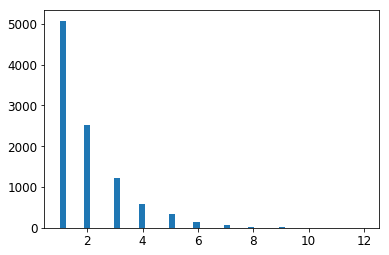

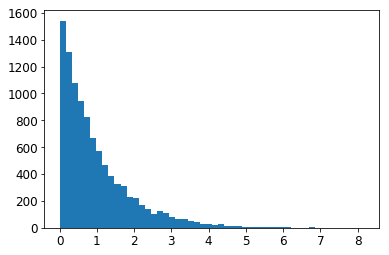

In [131]:
from scipy.stats import geom, expon
geom_distrib=geom(0.5).rvs(10000, random_state=42)
expon_distrib=expon(scale=1).rvs(10000, random_state=42)
plt.hist(geom_distrib, bins=50)
plt.show()
plt.hist(expon_distrib, bins=50)
plt.show()

# Exercises

## 1.
Question: Try a Support Vector Machine regressor (`sklearn.svm.SVR`), with various hyperparameters such as `kernel="linear"` (with various values for the `C` hyperparameter) or `kernel="rbf"` (with various values for the `C` and `gamma` hyperparameters). Don't worry about what these hyperparameters mean for now. How does the best `SVR` predictor perform?

- So I need to pick a few values for a few different kernals of support vector machines.
- GridSearchCV
    - Recall that GridSearchCV does cross validation
    - This is what we did earlier in the chaper:
    ```
    from sklearn.model_selection import GridSearchCV

    param_grid = [
        # try 12 (3×4) combinations of hyperparameters
        {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
        # then try 6 (2×3) combinations with bootstrap set as False
        {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
      ]

    forest_reg = RandomForestRegressor(random_state=42)
    # train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
    grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                               scoring='neg_mean_squared_error', return_train_score=True)
    grid_search.fit(housing_prepared, housing_labels)
    ```
    - `param_grid`
        - It's a list containing dictionaries
            - two in the example
            - The first have two keys, `n_estimators` mapped to a list of three item, and the other key is `max_features`, also mapped to a list.
            - The other dictionary has three keys
                - bootstrap which maps to only False
                - n_estimators, again maps to a list
                - and max_features again.
        - So each dictionary is a different parameter space to explore
            ```
            param_grid : dict or list of dictionaries
            Dictionary with parameters names (string) as keys and lists of
            parameter settings to try as values, or a list of such
            dictionaries, in which case the grids spanned by each dictionary
            in the list are explored. This enables searching over any sequence
            of parameter settings.
            ```
- So I need to try a few kernels, that can be an entry in the dictionary.  The question also says try a few values of `c` with the `linear` kernel, and a few values of `c` and `gamma` for the `rbf` kernel. So, sounds like I should do two dictionaries, 
one for each kernel
- Big example of the parameters in svm from sklearn:
http://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html
- Parameter `C`:
    ```
    C : float, optional (default=1.0)
    Penalty parameter C of the error term.
    ```
    - The C parameter trades off correct classification of training examples against maximization of the decision function’s margin. For larger values of C, a smaller margin will be accepted if the decision function is better at classifying all training points correctly. A lower C will encourage a larger margin, therefore a simpler decision function, at the cost of training accuracy. In other words C behaves as a regularization parameter in the SVM.
- gamma:
    ```
    gamma : float, optional (default='auto')
    Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.
    If gamma is 'auto' then 1/n_features will be used instead.
    ```
    - Intuitively, the gamma parameter defines how far the influence of a single training example reaches, with low values meaning ‘far’ and high values meaning ‘close’. The gamma parameters can be seen as the inverse of the radius of influence of samples selected by the model as support vectors.
    - protip gamma can't be negative.


In [140]:
GridSearchCV?

Init signature: GridSearchCV(estimator, param_grid, scoring=None, fit_params=None, n_jobs=1, iid=True, refit=True, cv=None, verbose=0, pre_dispatch='2*n_jobs', error_score='raise', return_train_score='warn')
Docstring:     
Exhaustive search over specified parameter values for an estimator.

Important members are fit, predict.

GridSearchCV implements a "fit" and a "score" method.
It also implements "predict", "predict_proba", "decision_function",
"transform" and "inverse_transform" if they are implemented in the
estimator used.

The parameters of the estimator used to apply these methods are optimized
by cross-validated grid-search over a parameter grid.

Read more in the :ref:`User Guide <grid_search>`.

Parameters
----------
estimator : estimator object.
    This is assumed to implement the scikit-learn estimator interface.
    Either estimator needs to provide a ``score`` function,
    or ``scoring`` must be passed.

param_grid : dict or list of dictionaries
    Dictionary with par

In [142]:
SVR?

Init signature: SVR(kernel='rbf', degree=3, gamma='auto', coef0=0.0, tol=0.001, C=1.0, epsilon=0.1, shrinking=True, cache_size=200, verbose=False, max_iter=-1)
Docstring:     
Epsilon-Support Vector Regression.

The free parameters in the model are C and epsilon.

The implementation is based on libsvm.

Read more in the :ref:`User Guide <svm_regression>`.

Parameters
----------
C : float, optional (default=1.0)
    Penalty parameter C of the error term.

epsilon : float, optional (default=0.1)
     Epsilon in the epsilon-SVR model. It specifies the epsilon-tube
     within which no penalty is associated in the training loss function
     with points predicted within a distance epsilon from the actual
     value.

kernel : string, optional (default='rbf')
     Specifies the kernel type to be used in the algorithm.
     It must be one of 'linear', 'poly', 'rbf', 'sigmoid', 'precomputed' or
     a callable.
     If none is given, 'rbf' will be used. If a callable is given it is
     used 

In [106]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

# set up the search grid
param_grid = [
    # try kernel = "linear" with a few values of c
    {"kernel": ["linear"], "C": [0.1, 1, 10, 100]},
    # try kernel="rbf" (with various values for the C and gamma hyperparameters)
    {"kernel": ["rbf"], "C": [0.1, 1, 10, 100], "gamma": [0.01, 0.1, 1, 100, 1000]}
]

# GridSearchCV needs an estimator
svm_estimator = SVR()

# make grid search thing / instance / object
grid_search = GridSearchCV(estimator=svm_estimator,
                           param_grid=param_grid,
                           cv=5,
                           scoring="neg_mean_squared_error",
                           verbose=2,
                           n_jobs=4)

In [159]:
svm_estimator

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [160]:
grid_search

GridSearchCV(cv=5, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=4,
       param_grid=[{'kernel': ['linear'], 'C': [0.1, 1, 10, 100]}, {'kernel': ['rbf'], 'C': [0.1, 1, 10, 100], 'gamma': [0.01, 0.1, 1, 100, 1000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=2)

In [161]:
# let's do it
grid_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:  8.4min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=4,
       param_grid=[{'kernel': ['linear'], 'C': [0.1, 1, 10, 100]}, {'kernel': ['rbf'], 'C': [0.1, 1, 10, 100], 'gamma': [0.01, 0.1, 1, 100, 1000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=2)

In [163]:
negative_mse = grid_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

71603.12196479437

In [164]:
grid_search.best_params_

{'C': 100, 'kernel': 'linear'}

I maxed out the values of `C` so it should probably go higher. Linear did better.


### Try again
Copied some set up from a sklearn tutorial on SVM [here](http://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html)


In [101]:
c_range = np.logspace(1, 5, 5)
gamma_range = np.logspace(1, 4, 4)

In [102]:
c_range

array([1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])

In [103]:
gamma_range

array([   10.,   100.,  1000., 10000.])

In [104]:
1.00000000e+05

100000.0

In [107]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

# set up the search grid
param_grid = [
    # try kernel = "linear" with a few values of c
    {"kernel": ["linear"], "C": c_range},
    # try kernel="rbf" (with various values for the C and gamma hyperparameters)
    {"kernel": ["rbf"], "C": c_range, "gamma": gamma_range}
]

# GridSearchCV needs an estimator
svm_estimator = SVR()

# make grid search thing / instance / object
grid_search = GridSearchCV(estimator=svm_estimator,
                           param_grid=param_grid,
                           cv=5,
                           scoring="neg_mean_squared_error",
                           verbose=2,
                           n_jobs=4)

In [108]:
# let's do it again
grid_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  3.1min
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed: 22.8min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=4,
       param_grid=[{'kernel': ['linear'], 'C': array([1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])}, {'kernel': ['rbf'], 'C': array([1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05]), 'gamma': array([   10.,   100.,  1000., 10000.])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=2)

In [ ]:
print("done!")

### 1. Solution

Question: Try a Support Vector Machine regressor (`sklearn.svm.SVR`), with various hyperparameters such as `kernel="linear"` (with various values for the `C` hyperparameter) or `kernel="rbf"` (with various values for the `C` and `gamma` hyperparameters). Don't worry about what these hyperparameters mean for now. How does the best `SVR` predictor perform?

In [115]:
from sklearn.model_selection import GridSearchCV

param_grid = [
        {'kernel': ['linear'], 'C': [10., 30., 100., 300., 1000., 3000., 10000., 30000.0]},
        {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0],
         'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
    ]

svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=4)
grid_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] C=10.0, kernel=linear ...........................................
[CV] C=10.0, kernel=linear ...........................................
[CV] C=10.0, kernel=linear ...........................................
[CV] C=10.0, kernel=linear ...........................................
[CV] ............................ C=10.0, kernel=linear, total=   6.2s
[CV] C=10.0, kernel=linear ...........................................
[CV] ............................ C=10.0, kernel=linear, total=   6.2s
[CV] C=30.0, kernel=linear ...........................................
[CV] ............................ C=10.0, kernel=linear, total=   6.2s
[CV] C=30.0, kernel=linear ...........................................
[CV] ............................ C=10.0, kernel=linear, total=   6.2s
[CV] C=30.0, kernel=linear ...........................................
[CV] ............................ C=30.0, kernel=linear, total=   6.1s
[CV] C=30.0, ke

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.5min


[CV] ......................... C=10000.0, kernel=linear, total=   9.8s
[CV] C=30000.0, kernel=linear ........................................
[CV] ......................... C=10000.0, kernel=linear, total=   8.3s
[CV] C=30000.0, kernel=linear ........................................
[CV] ......................... C=30000.0, kernel=linear, total=  13.8s
[CV] C=30000.0, kernel=linear ........................................
[CV] ......................... C=30000.0, kernel=linear, total=  14.0s
[CV] C=1.0, gamma=0.01, kernel=rbf ...................................
[CV] ......................... C=30000.0, kernel=linear, total=  14.5s
[CV] C=1.0, gamma=0.01, kernel=rbf ...................................
[CV] ......................... C=30000.0, kernel=linear, total=  14.0s
[CV] C=1.0, gamma=0.01, kernel=rbf ...................................
[CV] ......................... C=30000.0, kernel=linear, total=  12.4s
[CV] C=1.0, gamma=0.01, kernel=rbf ...................................
[CV] .

[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  9.1min


[CV] .................... C=30.0, gamma=1.0, kernel=rbf, total=   9.1s
[CV] C=30.0, gamma=3.0, kernel=rbf ...................................
[CV] .................... C=30.0, gamma=3.0, kernel=rbf, total=  11.0s
[CV] C=30.0, gamma=3.0, kernel=rbf ...................................
[CV] .................... C=30.0, gamma=3.0, kernel=rbf, total=  11.3s
[CV] C=100.0, gamma=0.01, kernel=rbf .................................
[CV] .................... C=30.0, gamma=3.0, kernel=rbf, total=  11.5s
[CV] C=100.0, gamma=0.01, kernel=rbf .................................
[CV] .................... C=30.0, gamma=3.0, kernel=rbf, total=  11.6s
[CV] C=100.0, gamma=0.01, kernel=rbf .................................
[CV] .................... C=30.0, gamma=3.0, kernel=rbf, total=  11.9s
[CV] C=100.0, gamma=0.01, kernel=rbf .................................
[CV] .................. C=100.0, gamma=0.01, kernel=rbf, total=  10.6s
[CV] C=100.0, gamma=0.01, kernel=rbf .................................
[CV] .

[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed: 15.1min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=4,
       param_grid=[{'kernel': ['linear'], 'C': [10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0, 10000.0, 30000.0]}, {'kernel': ['rbf'], 'C': [1.0, 3.0, 10.0, 30.0, 100.0, 300.0, 1000.0], 'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=2)

The best model achieves the following score (evaluated using 5-fold cross validation):

In [116]:
negative_mse = grid_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

70363.90313964167

That's much worse than the `RandomForestRegressor`. Let's check the best hyperparameters found:

In [117]:
grid_search.best_params_

{'C': 30000.0, 'kernel': 'linear'}

The linear kernel seems better than the RBF kernel. Notice that the value of `C` is the maximum tested value. When this happens you definitely want to launch the grid search again with higher values for `C` (removing the smallest values), because it is likely that higher values of `C` will be better.

## 2.

Question: Try replacing `GridSearchCV` with `RandomizedSearchCV`.

In [118]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

# see https://docs.scipy.org/doc/scipy/reference/stats.html
# for `expon()` and `reciprocal()` documentation and more probability distribution functions.

# Note: gamma is ignored when kernel is "linear"
param_distribs = {
        'kernel': ['linear', 'rbf'],
        'C': reciprocal(20, 200000),
        'gamma': expon(scale=1.0),
    }

svm_reg = SVR()
rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,
                                n_iter=50, cv=5, scoring='neg_mean_squared_error',
                                verbose=2, n_jobs=4, random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   6.3s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   6.3s
[CV] C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf ......
[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   6.3s
[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   6.4s
[CV] C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf ......
[CV] C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf ......
[CV]  C=629.782329591372, gamma=3.010121430917521,

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  2.0min


[CV]  C=108.30488238805073, gamma=0.3627537294604771, kernel=rbf, total=   9.1s
[CV] C=21.344953672647435, gamma=0.023332523598323388, kernel=linear .
[CV]  C=108.30488238805073, gamma=0.3627537294604771, kernel=rbf, total=   9.1s
[CV] C=21.344953672647435, gamma=0.023332523598323388, kernel=linear .
[CV]  C=108.30488238805073, gamma=0.3627537294604771, kernel=rbf, total=   9.0s
[CV] C=21.344953672647435, gamma=0.023332523598323388, kernel=linear .
[CV]  C=21.344953672647435, gamma=0.023332523598323388, kernel=linear, total=   6.0s
[CV] C=5603.270317432516, gamma=0.15023452872733867, kernel=rbf ......
[CV]  C=21.344953672647435, gamma=0.023332523598323388, kernel=linear, total=   6.0s
[CV] C=5603.270317432516, gamma=0.15023452872733867, kernel=rbf ......
[CV]  C=21.344953672647435, gamma=0.023332523598323388, kernel=linear, total=   5.9s
[CV] C=5603.270317432516, gamma=0.15023452872733867, kernel=rbf ......
[CV]  C=21.344953672647435, gamma=0.023332523598323388, kernel=linear, total=  

[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 12.3min


[CV]  C=16483.850529752886, gamma=1.4752145260435134, kernel=linear, total=  10.8s
[CV] C=101445.66881340064, gamma=1.052904084582266, kernel=rbf .......
[CV]  C=101445.66881340064, gamma=1.052904084582266, kernel=rbf, total=  47.4s
[CV] C=101445.66881340064, gamma=1.052904084582266, kernel=rbf .......
[CV]  C=101445.66881340064, gamma=1.052904084582266, kernel=rbf, total=  45.2s
[CV] C=56681.80859029545, gamma=0.9763011917123741, kernel=rbf .......
[CV]  C=101445.66881340064, gamma=1.052904084582266, kernel=rbf, total=  58.2s
[CV] C=56681.80859029545, gamma=0.9763011917123741, kernel=rbf .......
[CV]  C=101445.66881340064, gamma=1.052904084582266, kernel=rbf, total= 1.0min
[CV] C=56681.80859029545, gamma=0.9763011917123741, kernel=rbf .......
[CV]  C=56681.80859029545, gamma=0.9763011917123741, kernel=rbf, total=  19.0s
[CV] C=56681.80859029545, gamma=0.9763011917123741, kernel=rbf .......
[CV]  C=56681.80859029545, gamma=0.9763011917123741, kernel=rbf, total=  19.1s
[CV] C=56681.8085

[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed: 19.5min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
          fit_params=None, iid=True, n_iter=50, n_jobs=4,
          param_distributions={'kernel': ['linear', 'rbf'], 'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x112c40ba8>, 'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x112c406a0>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=2)

The best model achieves the following score (evaluated using 5-fold cross validation):

In [119]:
negative_mse = rnd_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

54767.99053704408

Now this is much closer to the performance of the `RandomForestRegressor` (but not quite there yet). Let's check the best hyperparameters found:

In [120]:
rnd_search.best_params_

{'C': 157055.10989448498, 'gamma': 0.26497040005002437, 'kernel': 'rbf'}

This time the search found a good set of hyperparameters for the RBF kernel. Randomized search tends to find better hyperparameters than grid search in the same amount of time.

Let's look at the exponential distribution we used, with `scale=1.0`. Note that some samples are much larger or smaller than 1.0, but when you look at the log of the distribution, you can see that most values are actually concentrated roughly in the range of exp(-2) to exp(+2), which is about 0.1 to 7.4.

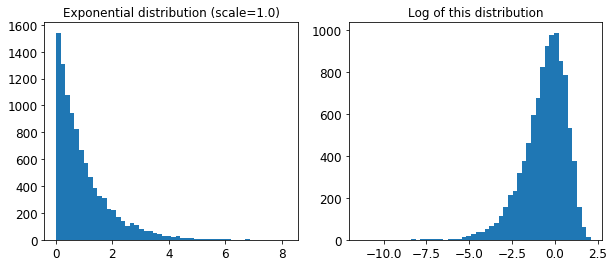

In [121]:
expon_distrib = expon(scale=1.)
samples = expon_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Exponential distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

The distribution we used for `C` looks quite different: the scale of the samples is picked from a uniform distribution within a given range, which is why the right graph, which represents the log of the samples, looks roughly constant. This distribution is useful when you don't have a clue of what the target scale is:

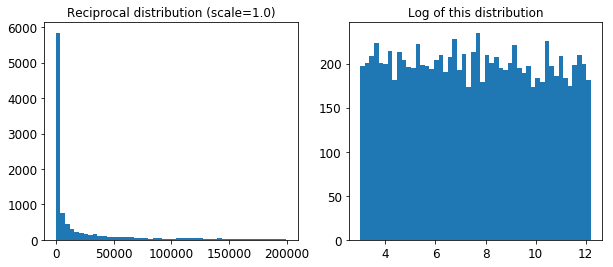

In [122]:
reciprocal_distrib = reciprocal(20, 200000)
samples = reciprocal_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Reciprocal distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

The reciprocal distribution is useful when you have no idea what the scale of the hyperparameter should be (indeed, as you can see on the figure on the right, all scales are equally likely, within the given range), whereas the exponential distribution is best when you know (more or less) what the scale of the hyperparameter should be.

## 3.

Question: Try adding a transformer in the preparation pipeline to select only the most important attributes.

In [123]:
from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

Note: this feature selector assumes that you have already computed the feature importances somehow (for example using a `RandomForestRegressor`). You may be tempted to compute them directly in the `TopFeatureSelector`'s `fit()` method, however this would likely slow down grid/randomized search since the feature importances would have to be computed for every hyperparameter combination (unless you implement some sort of cache).

Let's define the number of top features we want to keep:

In [124]:
k = 5

Now let's look for the indices of the top k features:

In [125]:
top_k_feature_indices = indices_of_top_k(feature_importances, k)
top_k_feature_indices

array([ 0,  1,  7,  9, 12])

In [126]:
np.array(attributes)[top_k_feature_indices]

array(['longitude', 'latitude', 'median_income', 'pop_per_hhold',
       'INLAND'], dtype='<U18')

Let's double check that these are indeed the top k features:

In [127]:
sorted(zip(feature_importances, attributes), reverse=True)[:k]

[(0.3661589806181342, 'median_income'),
 (0.1647809935615905, 'INLAND'),
 (0.10879295677551573, 'pop_per_hhold'),
 (0.07334423551601242, 'longitude'),
 (0.0629090704826203, 'latitude')]

Looking good... Now let's create a new pipeline that runs the previously defined preparation pipeline, and adds top k feature selection:

In [128]:
preparation_and_feature_selection_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k))
])

In [129]:
housing_prepared_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(housing)

Let's look at the features of the first 3 instances:

In [130]:
housing_prepared_top_k_features[0:3]

array([[-1.15604281,  0.77194962, -0.61493744, -0.08649871,  0.        ],
       [-1.17602483,  0.6596948 ,  1.33645936, -0.03353391,  0.        ],
       [ 1.18684903, -1.34218285, -0.5320456 , -0.09240499,  0.        ]])

Now let's double check that these are indeed the top k features:

In [131]:
housing_prepared[0:3, top_k_feature_indices]

array([[-1.15604281,  0.77194962, -0.61493744, -0.08649871,  0.        ],
       [-1.17602483,  0.6596948 ,  1.33645936, -0.03353391,  0.        ],
       [ 1.18684903, -1.34218285, -0.5320456 , -0.09240499,  0.        ]])

Works great!  :)

## 4.

Question: Try creating a single pipeline that does the full data preparation plus the final prediction.

In [132]:
prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k)),
    ('svm_reg', SVR(**rnd_search.best_params_))
])

In [133]:
prepare_select_and_predict_pipeline.fit(housing, housing_labels)

Pipeline(memory=None,
     steps=[('preparation', ColumnTransformer(n_jobs=1, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('attribs_adder'... gamma=0.26497040005002437, kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False))])

Let's try the full pipeline on a few instances:

In [134]:
some_data = housing.iloc[:4]
some_labels = housing_labels.iloc[:4]

print("Predictions:\t", prepare_select_and_predict_pipeline.predict(some_data))
print("Labels:\t\t", list(some_labels))

Predictions:	 [203214.28978849 371846.88152572 173295.65441612  47328.3970888 ]
Labels:		 [286600.0, 340600.0, 196900.0, 46300.0]


Well, the full pipeline seems to work fine. Of course, the predictions are not fantastic: they would be better if we used the best `RandomForestRegressor` that we found earlier, rather than the best `SVR`.

## 5.

Question: Automatically explore some preparation options using `GridSearchCV`.

In [136]:
param_grid = [
        {'preparation__num__imputer__strategy': ['mean', 'median', 'most_frequent'],
         'feature_selection__k': list(range(1, len(feature_importances) + 1))}
]

grid_search_prep = GridSearchCV(prepare_select_and_predict_pipeline, param_grid, cv=5,
                                scoring='neg_mean_squared_error', verbose=2, n_jobs=4)
grid_search_prep.fit(housing, housing_labels)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=mean, total=   6.4s
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=mean, total=   6.4s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=mean, total=   6.4s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=median 
[CV] feature_selection__k=1, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=mean, total=   6.4s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=median 
[CV]  feature_select

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.4min


[CV]  feature_selection__k=3, preparation__num__imputer__strategy=mean, total=   6.6s
[CV] feature_selection__k=3, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=3, preparation__num__imputer__strategy=mean, total=   6.6s
[CV] feature_selection__k=3, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=3, preparation__num__imputer__strategy=median, total=   6.5s
[CV] feature_selection__k=3, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=3, preparation__num__imputer__strategy=median, total=   7.1s
[CV] feature_selection__k=3, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_selection__k=3, preparation__num__imputer__strategy=median, total=   6.9s
[CV] feature_selection__k=3, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_selection__k=3, preparation__num__imputer__strategy=median, total=   6.9s
[CV] feature_selection__k=3, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_sel

[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  9.0min


[CV]  feature_selection__k=11, preparation__num__imputer__strategy=median, total=  17.6s
[CV] feature_selection__k=11, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=11, preparation__num__imputer__strategy=mean, total=  19.8s
[CV] feature_selection__k=11, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=11, preparation__num__imputer__strategy=median, total=  17.0s
[CV] feature_selection__k=11, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_selection__k=11, preparation__num__imputer__strategy=median, total=  17.8s
[CV] feature_selection__k=11, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_selection__k=11, preparation__num__imputer__strategy=median, total=  20.3s
[CV] feature_selection__k=11, preparation__num__imputer__strategy=most_frequent 
[CV]  feature_selection__k=11, preparation__num__imputer__strategy=median, total=  21.3s
[CV] feature_selection__k=11, preparation__num__imputer__strategy=most_freque

[Parallel(n_jobs=4)]: Done 240 out of 240 | elapsed: 19.3min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('preparation', ColumnTransformer(n_jobs=1, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('attribs_adder'... gamma=0.26497040005002437, kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params=None, iid=True, n_jobs=4,
       param_grid=[{'preparation__num__imputer__strategy': ['mean', 'median', 'most_frequent'], 'feature_selection__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=2)

In [137]:
grid_search_prep.best_params_

{'feature_selection__k': 15,
 'preparation__num__imputer__strategy': 'most_frequent'}

The best imputer strategy is `most_frequent` and apparently almost all features are useful (15 out of 16). The last one (`ISLAND`) seems to just add some noise.

# All done!

Congratulations! You already know quite a lot about Machine Learning. :)